# 实战 Kaggle 比赛：预测房价

In [1]:
# 下载和缓存数据集
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下面的download函数用来下载数据集，将数据集缓存在本地目录（默认情况下为../data）中，并返回下载文件的名称。如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配，我们将使用缓存的文件，以避免重复的下载。

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

我们还实现了两个额外的实用函数：一个是下载并解压缩一个zip或tar文件，另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [3]:
def download_extract(name, folder=None):
    """下载并解压zip/tar文件。"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else  data_dir
def download_all():
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from d2l import tensorflow as d2l

In [6]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [7]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [8]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


让我们看看前四个和最后两个特征，以及相应标签（房价）

In [9]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


第一个特征是ID，这有助于模型识别每个训练样本。虽然这很方便，但它不携带任何用于预测的信息。因此，在将数据提供给模型之前，我们将其从数据集中删除。

In [10]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# 数据预处理 先Pandas，后转为Numpy

缺失值的补充：启发式方法，将所有缺失的值替换为相应特征的平均值  
特征值缩放：归一化（我们标准化数据有两个原因。首先，它方便优化。其次，因为我们不知道哪些特征是相关的，所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大。）

In [13]:
# 数字特征的先处理
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后的数据，缺失值可设为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [15]:
# 离散值，将非数字化的特征通过"热编码"处理为数字特征
# 利用pd的get_dummies实现
# `Dummy_na=True` 将“na”（缺失值）视为有效的特征值，并为其创建指示符特征。
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [21]:
# 之前做过连接，取前n_train为训练集，后面为验证集或测试集
n_train = train_data.shape[0]
train_features = tf.constant(all_features[:n_train].values, dtype=d2l.float32)
test_features = tf.constant(all_features[n_train:].values, dtype=d2l.float32)
train_labels = tf.constant(
    train_data.SalePrice.values.reshape(-1, 1), dtype=d2l.float32)

# 训练

我们训练一个带有损失平方的线性模型,为何？  
线性模型提供了一种健全性检查，以查看数据中是否存在有意义的信息。   
如果我们在这里不能做得比随机猜测更好，那么我们很可能存在数据处理错误。  
如果一切顺利，线性模型将作为基线模型，让我们直观地知道简单的模型离报告最好的模型有多近，让我们感觉到我们应该从更酷炫的模型中获得多少收益。

In [35]:
loss = tf.keras.losses.MeanSquaredError()

def get_net():
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(
        1, kernel_regularizer = tf.keras.regularizers.l2(weight_decay)))
    return net

对于房价，就像股票价格一样，我们关心的是相对数量，而不是绝对数量。  
因此，我们更关心相对误差 y−y^/y ，而不是绝对误差 y−y^。

解决这个问题的一种方法是用价格预测的对数来衡量差异  
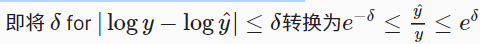  
预测价格的对数与真实标签价格的对数之间出现以下均方差根误差：  
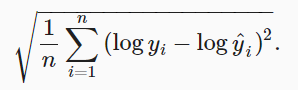

In [36]:
def log_rmse(y_true, y_pred):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = tf.clip_by_value(y_pred, 1, float('inf'))
    return tf.sqrt(tf.reduce_mean(loss(
        tf.math.log(y_true), tf.math.log(clipped_preds))))

In [37]:
# 将借助Adam优化器
# 这个优化器的主要吸引力在于
# 尽管在提供无限资源进行超参数优化方面没有做得更好（有时更差），
# 但人们发现它对初始学习率不那么敏感。
def train(net, train_features, train_labels, test_features, test_labels, 
         num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的就是Adam优化算法
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    net.complie(loss=loss, optimizer=optimizer)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = loss(y, y_hat)
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            optimizer.apply_gradients(zip(grads, params))
        train_ls.append(log_rmse(train_labels, net(train_features)))
        if test_labels is not None:
            test_ls.append(log_rmse(test_labels, net(test_features)))
    return train_ls, test_ls

# K折交叉验证

我们首先需要一个函数，在 K 折交叉验证过程中返回第 i 折的数据。它选择第 i 个切片作为验证数据，其余部分作为训练数据。  
注意，这并不是处理数据的最有效方法，如果我们的数据集大得多，我们肯定会做一些更聪明的改变。但是这种改变所增加的复杂性可能会使代码看起来更乱。在这里可以忽略这些改变，因为我们的问题很简单。

In [30]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j* fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx,:], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], 0)
            y_train = tf.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [31]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
          batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                  weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i ==0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                    xlabel = 'epoch', ylabel='rmse', xlim=[1,num_epochs],
                    legend=['train', 'valid'], yscale='log')
        print(f'fold{i + 1}, train log rmse {float(train_ls[-1]):f},'
              f'valid log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

# 模型选择

In [33]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                         weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f},'
      f'平均验证log rmse：{float(valid_l):f}')

AttributeError: 'Sequential' object has no attribute 'complie'